In [3]:
import numpy as np
from to_delete.Transitive_Annotation_Utils import *
from scipy.stats import pearsonr, ks_2samp

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

rcParams = {'font.size': 18 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)

def Plot_Box_Plots(boxes, positions, color, ax, widths = 0.45, lw = 3.5, 
                   scatter = True, deviation = 0.045, s = 70, alpha = 0.1, sample = 1000):
    flierprops = dict(marker='x', markersize=0.5, linestyle='none')
    whiskerprops = dict(color='black',linewidth=1.5)
    capprops = dict(color='black', linewidth=0.5)
    medianprops = dict(linewidth=1.5, linestyle='-', color='black')
    box = ax.boxplot(boxes, positions=positions, whis = [5,95], widths = [widths]*len(positions),
                     showfliers = False, boxprops = dict(linestyle='-', linewidth=lw, color='black'), 
                     flierprops = flierprops, whiskerprops = whiskerprops, capprops = capprops, 
                     medianprops = medianprops)
    
    if(scatter):
        for i in range(0, len(positions)):
            if len(boxes[i]) < sample:
                y = boxes[i]
            else:
                y = np.random.choice(boxes[i], sample)
                y = np.append(y, [max(boxes[i])])
            x = np.random.normal(positions[i], deviation, size=len(y))
            ax.scatter(x,y,color = color,alpha = alpha, marker = 'o', s = s)

### Load output of rdp classifier without transitive annotations

In [4]:
non_adv_taxa = '/Users/harihara/Mount-2/projects/RDP_Outlier_Analysis/Gates_Dataset_Experiments/All3000.final.centers.out'
df_wo_adv = Parse_RDP_Output(non_adv_taxa)
df_wo_adv = df_wo_adv[['genus','family']]

### Load summary information for "worst case adversarial example analysis"

In [6]:
data_dir = '/Users/harihara/Mount-2/projects/RDP_Outlier_Analysis/RDP_Sensitivity_Analysis/Adversarial_DB_All_Seqs/'
files = listdir(data_dir)
files.sort()
out = []
for f in files:
    if f.startswith(".") or f == 'nan': continue
    S = open(data_dir+f+'/Adverserial_Trained_'+f+'.summary').readlines()
    for s in S: out.append(eval(s.replace("nan","0")))

df_Adversarial = pd.DataFrame(out)
df_Adversarial['D'] = df_Adversarial['SeqID'].apply(Extract_Parameter, filt="d")
df_Adversarial['#Seqs-GA(adv)'] = df_Adversarial['#Seqs-GA(adv)'].astype(int)
df_Adversarial[['SA','SB']] = df_Adversarial['SeqID'].apply(Extract_SA_SB)
df_Adversarial = df_Adversarial.set_index(['SA','SB'])

### Load summary information for adding "query" sequences as adversarial examples(control)

In [7]:
data_dir = '/Users/harihara/Mount-2/projects/RDP_Outlier_Analysis/RDP_Sensitivity_Analysis/Test-Control/'
S = open(data_dir+'Adverserial_Trained.summary').readlines()
out = []
for s in S: 
    out.append(eval(s.replace("nan","0")))

df_control = pd.DataFrame(out)
df_control = df_control.rename(columns = {'SeqID':'Adversarial_Seq'})
df_control['SeqID'] = (df_control['Adversarial_Seq'].str.replace("Control_Seq_","").str.split("_").str[0]+'_'+
                       df_control['Adversarial_Seq'].str.replace("Control_Seq_","").str.split("_").str[1])
df_control = df_control.set_index('SeqID')

data_dir = '/Users/harihara/Mount-2/projects/RDP_Outlier_Analysis/Gates_Dataset_Experiments/Adversarial_Seqs_Summary/'
   
files = listdir(data_dir)
df_delta_control = pd.DataFrame()
for f in files:
    if not f.startswith("."):
        df = pd.read_csv(data_dir+f, sep = "\t")
        df_delta_control = pd.concat([df, df_delta_control], axis = 0)
df_delta_control = df_delta_control.reset_index()
df_delta_control[['SA','SB']] = df_delta_control['Edit_Path'].apply(Extract_SA_SB)
df_delta_control = df_delta_control.rename(columns = {'Edit_Path':'SeqID'})

del df_delta_control['Unnamed: 0']
df_sel_A = df_delta_control[['SA', 'DA']].rename(columns = {'SA':'SeqID', 'DA':'Delta'})
df_sel_B = df_delta_control[['SB', 'DB']].rename(columns = {'SB':'SeqID', 'DB':'Delta'})
df_delta_control = pd.concat([df_sel_A,df_sel_B], axis = 0)
df_delta_control = df_delta_control.groupby('SeqID').min()
df_control = df_control.join(df_delta_control)


#### Identify worstcase case adversarial pairs for control sequences

In [8]:
index = df_control.index.tolist()
Adv_Pairs = []
for i in range(0, len(index)):
    for j in range(i+1, len(index)):
        if index[i]!=index[j]:
            if df_wo_adv.loc[index[i]]['family'] == df_wo_adv.loc[index[j]]['family']:
                Adv_Pairs.append((index[i], index[j]))
Worst_Adv_Pairs = []
for a in Adv_Pairs:
    try:
        x = df_Adversarial.loc[a]
        Worst_Adv_Pairs.append(a)
    except KeyError:
        try:
            y = df_Adversarial.loc[(a[1],a[0])]
            Worst_Adv_Pairs.append((a[1],a[0]))
        except KeyError:
            continue
df_Control_Worst_Case = df_Adversarial.loc[Worst_Adv_Pairs]

### Calculate Statistics

In [9]:
rho_delta_flips, p_delta_flips = pearsonr(df_control['Delta'], df_control['Flips'])
print("Correlation Coeffeicient, Distance to decision boundary, #Flips (", 
      round(rho_delta_flips, 2), round(p_delta_flips, 2), ')')

rho_adv_GA_Abund, p_adv_GA_Abund = pearsonr(df_Adversarial['GA_Taxa_Counts(DB)'], df_Adversarial['Flips'])
print("Correlation Coeffeicient, Taxa Counts(Transitively annotated sequence), #Flips (",
     round(rho_adv_GA_Abund,2), round(p_adv_GA_Abund,2), ")")

rho_adv_GB_Abund, p_adv_GB_Abund = pearsonr(df_Adversarial['GB_Taxa_Counts(DB)'], df_Adversarial['Flips'])
print("Correlation Coeffeicient, Taxa Counts(Sequence that changed labels), #Flips (",
     round(rho_adv_GB_Abund,2), round(p_adv_GB_Abund,2), ")")

KS_Controls_Worstcase, p_Controls_Worstcase = ks_2samp(df_control['Flips'], df_Control_Worst_Case['Flips'])
print("KS Statistic- Control, Transitively annotated Sequence (",
      round(KS_Controls_Worstcase, 2), round(p_Controls_Worstcase),")\n")

print('Median number of label changes with query as controls', df_control['Flips'].median())
print('Median number of label changes with worst case controls', df_Control_Worst_Case['Flips'].median(),'\n')

Correlation Coeffeicient, Distance to decision boundary, #Flips ( -0.17 0.0 )
Correlation Coeffeicient, Taxa Counts(Transitively annotated sequence), #Flips ( -0.05 0.0 )
Correlation Coeffeicient, Taxa Counts(Sequence that changed labels), #Flips ( -0.02 0.04 )
KS Statistic- Control, Transitively annotated Sequence ( 0.15 0 )

Median number of label changes with query as controls 5.0
Median number of label changes with worst case controls 6.0 



Text(-0.03, 0.45, 'senstivity of the RDP classifier\n(number of query sequences that changed labels)')

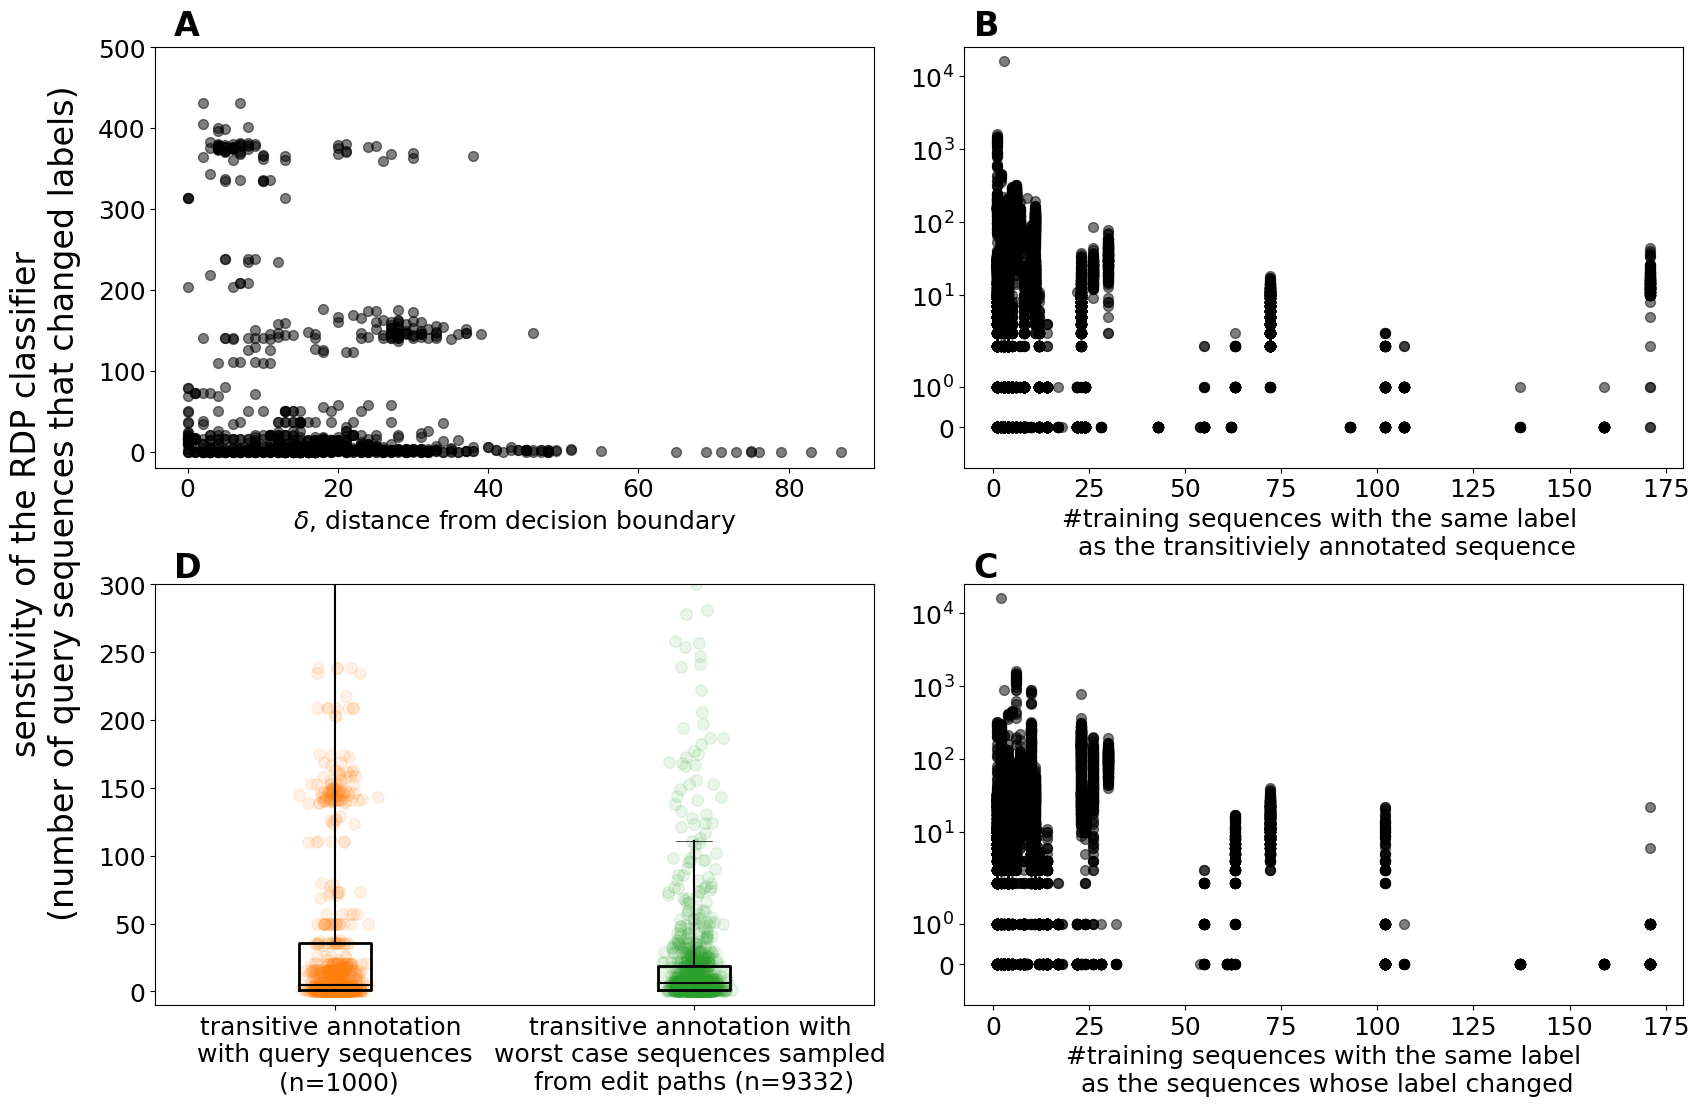

In [10]:
plots_dir = '/Users/harihara/Research-Activities/Plots/RDP_Outlier_Analysis/'
if not isdir(plots_dir):
    mkdir(plots_dir)

plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (16,16))
gs0 = fig.add_gridspec(2, 1,height_ratios=[2,1])

gs1 = gs0[0].subgridspec(2, 2)
ax1, ax2 = fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])
ax4, ax3 = fig.add_subplot(gs1[2]), fig.add_subplot(gs1[3])
gs2 = gs0[1].subgridspec(1,1)

df_control.plot.scatter('Delta', 'Flips', ax = ax1, color = 'black', s= 50, alpha = 0.5, rasterized = True,
                      xlabel= r'$\delta$, distance from decision boundary', ylabel = '')
ax1.set_ylim(-20, 500)

df_Adversarial.plot.scatter('GA_Taxa_Counts(DB)', 'Flips', ax = ax2, s = 50, color = 'black', alpha = 0.5, 
                            xlabel = '#training sequences with the same label \n as the transitiviely annotated sequence',rasterized = True, ylabel = "")
ax2.set_yscale('symlog')
ax2.set_yticks([0, 1, 10, 100, 1000, 10000])
ax2.set_ylim([-1,25000])

df_Adversarial.plot.scatter('GB_Taxa_Counts(DB)', 'Flips', ax = ax3, s = 50, color = 'black', alpha = 0.5,
                            rasterized = True, ylabel = "",
                            xlabel = '#training sequences with the same label\n as the sequences whose label changed')
ax3.set_yscale('symlog')
ax3.set_yticks([0, 1, 10, 100, 1000, 10000])
ax3.set_ylim([-1,25000])

Plot_Box_Plots([df_control['Flips'].tolist()], [1], 'C1', ax4, widths = 0.2, lw = 2, 
                scatter = True, deviation = 0.032, s = 70, alpha = 0.1)
Plot_Box_Plots([df_Control_Worst_Case[df_Control_Worst_Case['Flips'] >= 0]['Flips'].tolist()], [2], 'C2', ax4, 
                widths = 0.2, lw = 2, scatter = True, deviation = 0.032, s = 70, alpha = 0.1)
ax4.set_xticklabels(['transitive annotation \nwith query sequences\n (n='+str(len(df_control))+')', 
                     'transitive annotation with \nworst case sequences sampled \nfrom edit paths (n='+
                     str(len(df_Control_Worst_Case))+')'])
ax4.set_ylim([-10,300])

fig.text(0.05,0.999,'A',fontsize = 24, fontweight = 'bold')
fig.text(0.55,0.999,'B',fontsize = 24, fontweight = 'bold')
fig.text(0.55,0.66,'C',fontsize = 24, fontweight = 'bold')
fig.text(0.05,0.66,'D',fontsize = 24, fontweight = 'bold')
fig.text(-0.03, 0.45, 'senstivity of the RDP classifier\n(number of query sequences that changed labels)',
         rotation = 90, size = 24, ha = 'center')

#fig.savefig(plots_dir+'Fig-3.pdf',bbox_inches="tight")